In [1]:
import torch
from torch import nn

In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.has_mps

True

In [4]:
device = "mps" if torch.has_mps else "cpu"

In [5]:
from pathlib import Path

In [6]:
data_path  =Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"


Random image path: data/pizza_steak_sushi/train/steak/3245622.jpg
Image class: steak
Image height: 262
Image width: 512


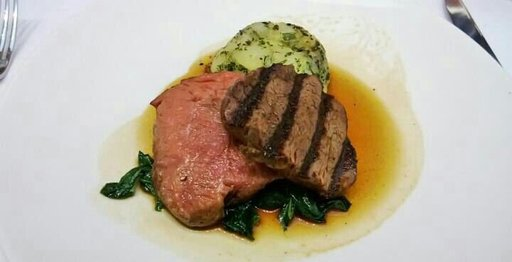

In [7]:
import random
from PIL import Image

random.seed(421)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
## Image Transformation 
data_transform = transforms.Compose([
    ## Resizing The Image ##
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
    transforms.ToTensor()

])

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


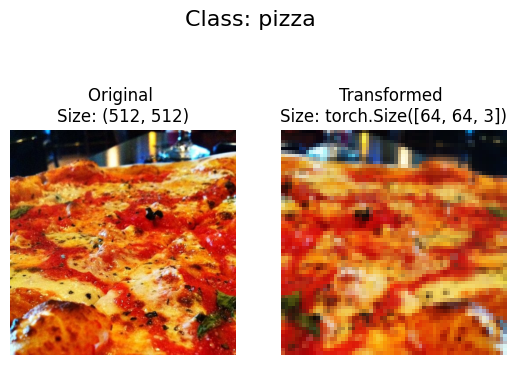

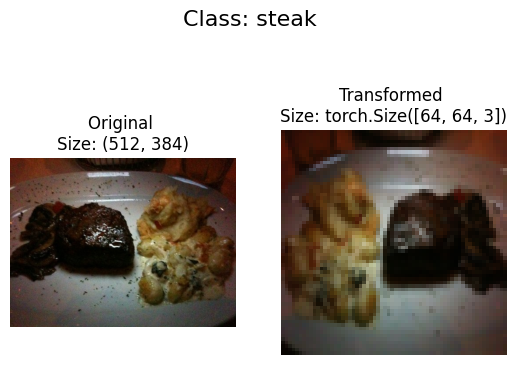

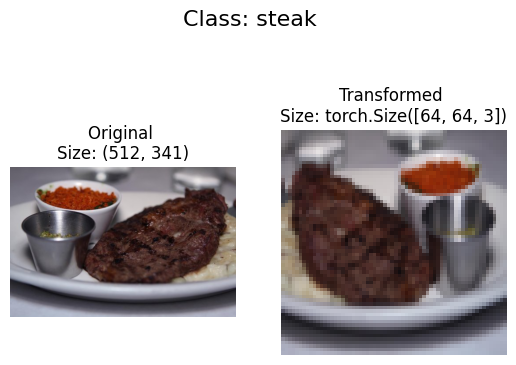

In [11]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [12]:
# Using Image Folder to create DataSets
from torchvision import datasets

In [13]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

In [14]:
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [15]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
class_dict = train_data.class_to_idx

In [17]:
class_name = train_data.classes

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
img, label = train_data[0][0], train_data[0][1]

In [20]:
img.shape

torch.Size([3, 64, 64])

In [21]:
img.shape

torch.Size([3, 64, 64])

In [22]:
img_permute = img.permute(1, 2, 0)

In [23]:
img_permute.shape

torch.Size([64, 64, 3])

Text(0.5, 1.0, 'pizza')

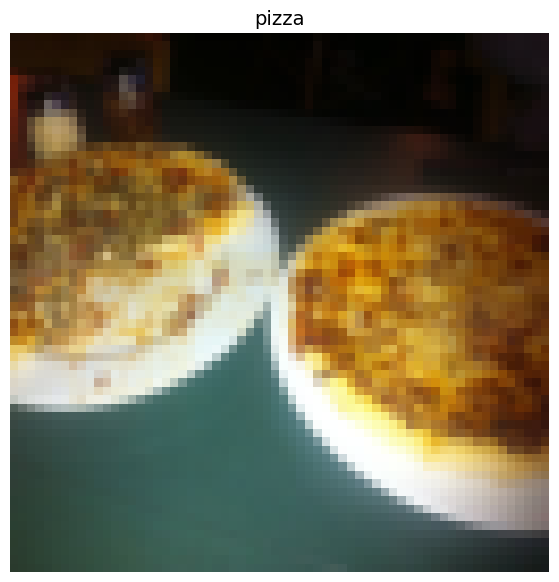

In [24]:
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_name[label], fontsize=14)

In [25]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x1065ecb20>,
 <torch.utils.data.dataloader.DataLoader at 0x16a4c29a0>)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Using Custom DataSet 

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['.DS_Store', 'pizza', 'steak', 'sushi']


In [29]:
class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None) -> None:

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        self.transform = transform

        self.classes = ['pizza', 'steak', 'sushi']
        self.class_to_idx = {'pizza': 0, 'steak': 1, 'sushi': 2}


    def load_image(self, index:int) -> Image.Image:
        """Open Image from path via index and returns it

        :param index: Index
        :type index: int

        :return: Image
        :rtype: Image.Image
        """

        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)
    

    ## Overriding this is required 
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        """Returns One Sample of data; (data  & Label)


        :param index: _description_
        :type index: int
        :return: _description_
        :rtype: Tuple[torch.Tensor, int]
        """

        img = self.load_image(index=index)

        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        
        else:
            return img, class_idx
        

In [30]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [31]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x16a4f9bb0>,
 <__main__.ImageFolderCustom at 0x16a4f9910>)

In [32]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [33]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [34]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [35]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

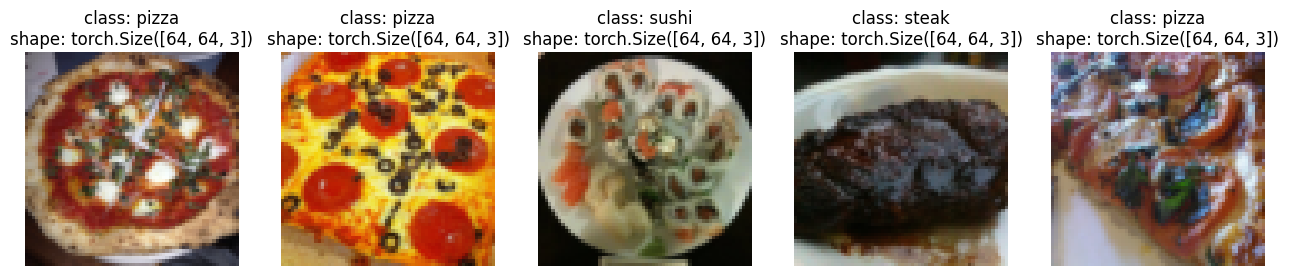

In [37]:
display_random_images(train_data_custom, 
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

## DataLoader

In [38]:
train_dataloader_cs = DataLoader(dataset=train_data_custom,
                                 batch_size=10,
                                 num_workers=0,
                                 shuffle=True)

test_dataloader_cs = DataLoader(dataset=test_data_custom,
                                batch_size=10,
                                num_workers=0,
                                shuffle=False)

In [39]:

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_cs))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([10, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([10])


In [40]:
## Image Transformation 
data_transform = transforms.Compose([
    ## Resizing The Image ##
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
    transforms.ToTensor()

])

In [41]:
transform_new = torch.nn.Sequential(
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
)

In [42]:
train_data_no_ts = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=None)

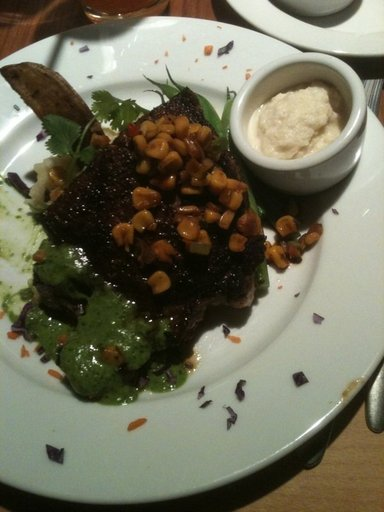

In [43]:
train_data_no_ts[0][0]

In [44]:
from torchvision import transforms

In [45]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31)

])

In [46]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

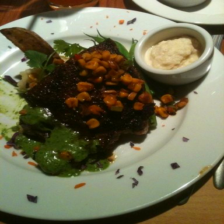

In [55]:
ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)[0][0]

## TinyVGG without Data Augmentation

In [56]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [57]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)


In [58]:
import os
from torch.utils.data import DataLoader

In [59]:
os.cpu_count()

10

In [60]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [61]:
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

In [62]:
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [63]:
class TinyVGG(nn.Module):
    """TinyVGG Architecture


    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super(TinyVGG, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13,
                      out_features=output_shape)
        )

    
    def forward(self, x:torch.Tensor):

        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
    

        return x

In [64]:
torch.manual_seed(45)

In [65]:
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=3)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [68]:
model_0.to(device="cpu")

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [69]:
image_batch , label_batch = next(iter(train_dataloader_simple))

In [70]:
model_0(image_batch)

tensor([[ 0.0930, -0.0588, -0.0495],
        [ 0.0909, -0.0606, -0.0494],
        [ 0.0801, -0.0768, -0.0547],
        [ 0.0837, -0.0608, -0.0536],
        [ 0.1015, -0.0697, -0.0431],
        [ 0.0753, -0.0604, -0.0586],
        [ 0.0884, -0.0615, -0.0541],
        [ 0.0940, -0.0570, -0.0537],
        [ 0.0892, -0.0622, -0.0520],
        [ 0.0901, -0.0722, -0.0509],
        [ 0.0943, -0.0647, -0.0549],
        [ 0.0766, -0.0552, -0.0556],
        [ 0.0885, -0.0588, -0.0477],
        [ 0.0809, -0.0667, -0.0509],
        [ 0.0921, -0.0741, -0.0546],
        [ 0.0807, -0.0702, -0.0625],
        [ 0.0816, -0.0563, -0.0593],
        [ 0.0894, -0.0676, -0.0538],
        [ 0.0907, -0.0614, -0.0505],
        [ 0.0894, -0.0730, -0.0467],
        [ 0.0931, -0.0604, -0.0568],
        [ 0.0926, -0.0611, -0.0490],
        [ 0.0840, -0.0594, -0.0462],
        [ 0.0943, -0.0664, -0.0510],
        [ 0.0954, -0.0516, -0.0410],
        [ 0.0841, -0.0658, -0.0546],
        [ 0.0973, -0.0702, -0.0412],
 

In [71]:
model_0(train_data_simple[0][0].unsqueeze(dim=0))

tensor([[ 0.0747, -0.0800, -0.0482]], grad_fn=<AddmmBackward0>)

In [72]:
from torchinfo import summary

In [76]:
summary(model_0, input_size=[1,3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia